In [ ]:
!pip install transformers
!pip install tensorflow_addons

In [ ]:
!pip install datasets

# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

In [4]:
import os
import pandas as pd
import numpy as np
import re
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from copy import deepcopy

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [5]:
device = torch.device("cuda:0")

# Load Data

In [6]:
file_path = '/content/drive/MyDrive/Pal-ette/preprocessed_data'
df = pd.read_csv(os.path.join(file_path, 'merged_7-emotions_morphs.csv'))
df.head()

,emotion,preprocessed,morphs
0,분노,"자기야 너무 화가나 퇴근 후 집에 들어왔는데, 키우는 반려견이 휴지통과 봉투를 파...",자기야 너무 화가 퇴근 후 집 들어왔는데 키우는 반려견 휴지통 봉투 파헤쳐놨어 오늘...
1,분노,오늘 고생하고 집에왔는데 장면을 보고 기분이 안좋았겠다 자기가 화나니까 나도 속상...,오늘 고생 집 왔는데 장면 보고 기분 안좋았겠다 자기 화나니까 나도 속상하고 기분 ...
2,분노,"내가 출근 전에 청소를 다했었거든 그런데, 집이 더럽게 되었어 청소를 할 생각하...",내 출근 전 청소 다 했었거든 집 더럽게 되었어 청소 할 생각 하니 너무 기분 안좋...
3,분노,"나였어도, 아침에 내서 치웠는데, 저녁에 청소를 해야 하면 기분이 안좋을 같아 나...",나였어도 아침 내서 치웠는데 저녁 청소 해야 하면 기분 안좋을 같아 나도 키우는 강...
4,분노,강아지를 데려온지 안되서 그런지 힘든게 한두개가 아니야 밤에는 짖어서 잠을 설치기...,강아지 데려온지 안되서 그런지 힘든게 개 아니야 밤 짖어서 잠 설치 기도 해 휴지통...


In [7]:
df[df['preprocessed'].isna()]

,emotion,preprocessed,morphs


In [8]:
df[df['morphs'].isna()]

,emotion,preprocessed,morphs
461003,중립,50! 25!,NaN
463839,중립,어? 아,NaN
467571,중립,아네?,NaN
483326,중립,야! 어,NaN
485648,중립,아네?,NaN
488555,중립,야!! 어?,NaN
502953,슬픔,아,NaN
502955,슬픔,하,NaN
503451,슬픔,하,NaN
503470,슬픔,어휴,NaN


In [9]:
df.dropna(subset = ['morphs'], inplace=True)
df[df['morphs'].isna()]

,emotion,preprocessed,morphs


In [10]:
df.reset_index(drop=True, inplace=True)
df

,emotion,preprocessed,morphs
0,분노,"자기야 너무 화가나 퇴근 후 집에 들어왔는데, 키우는 반려견이 휴지통과 봉투를 파...",자기야 너무 화가 퇴근 후 집 들어왔는데 키우는 반려견 휴지통 봉투 파헤쳐놨어 오늘...
1,분노,오늘 고생하고 집에왔는데 장면을 보고 기분이 안좋았겠다 자기가 화나니까 나도 속상...,오늘 고생 집 왔는데 장면 보고 기분 안좋았겠다 자기 화나니까 나도 속상하고 기분 ...
2,분노,"내가 출근 전에 청소를 다했었거든 그런데, 집이 더럽게 되었어 청소를 할 생각하...",내 출근 전 청소 다 했었거든 집 더럽게 되었어 청소 할 생각 하니 너무 기분 안좋...
3,분노,"나였어도, 아침에 내서 치웠는데, 저녁에 청소를 해야 하면 기분이 안좋을 같아 나...",나였어도 아침 내서 치웠는데 저녁 청소 해야 하면 기분 안좋을 같아 나도 키우는 강...
4,분노,강아지를 데려온지 안되서 그런지 힘든게 한두개가 아니야 밤에는 짖어서 잠을 설치기...,강아지 데려온지 안되서 그런지 힘든게 개 아니야 밤 짖어서 잠 설치 기도 해 휴지통...
...,...,...,...
519680,상처,너무 지친다,너무 지친다
519681,상처,갈수록 지쳐요,갈수록 지쳐요
519682,상처,그 짓도 한 두 번이지,그 짓도 한 두 번
519683,상처,이제 저도 한계가 온 거 같아요,이제 저 한계 온 거 같아요


### LabelEncoder

In [11]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['label'] = LE.fit_transform(df['emotion'])

labels = LE.classes_
print(len(labels), labels)

7 ['기쁨' '당황' '분노' '불안' '상처' '슬픔' '중립']


In [12]:
df['emotion'].value_counts()

emotion
분노    95070
기쁨    91473
슬픔    74673
불안    68314
상처    65900
당황    65735
중립    58520
Name: count, dtype: int64

In [13]:
df_part = df.sample(frac=0.1, random_state=0)
df_part.reset_index(drop=True, inplace=True)
df_part

,emotion,preprocessed,morphs,label
0,분노,"그래, 형이 딱히 걸로 스트레스 해소할 거리도 없긴 하지 형수는 건강 걱정한 아닐...",그래 형 딱히 걸 스트레스 해소 할 거리 없긴 하지 형수 건강 걱정 아닐까 너무 화...,2
1,상처,남자 친구가 사실은 기혼 상태이더라고 나한테는 이미 이혼했다고 했었거든 그게 말...,남자 친구 사실 기혼 상태 더 나 는 이미 이혼 했다고 했었거든 그게 말 내 제대로...,4
2,상처,"좋은 인연이 분명히 있을 거야 너는 빠지는 구석도 없고 좋은 사람이니까, 좋은 사...",좋은 인연 분명히 있을 너 빠지는 구석 없고 좋은 사람 좋은 사람 만나기 위 해서라...,4
3,상처,맞아요 쌍둥이들이 미숙아로 태어나서 그런지 정말 먹는 거만큼은 먹이고 싶어요 우...,맞아요 쌍둥이 미숙아 태어나서 그런지 정말 먹는 거 먹이 싶어요 우리 안 먹더라도 ...,4
4,상처,"밖에서 버스를 10분 넘게 기다리는데, 계속 안 오길래 지하철역까지 15분 걸어갔거...",밖 버스 넘게 기다리는데 계속 안 오길래 지하철역 걸어갔거든 버스 기다리면서 이미 ...,4
...,...,...,...,...
51963,기쁨,칭찬해 주니 정말 기분 좋다 격려해 줘서 정말 고마워 나도 너처럼 성실한 사람을...,칭찬 해 주니 정말 기분 좋다 격려 해 줘서 정말 고마워 나도 너 성실한 사람 보면...,0
51964,불안,저도 무대 공포증이 있어서 떨리고 당황스러운 감정을 압니다 평소 연습한 것보다 실...,저 무대 공포증 있어서 떨리고 당황 감정 압니 평소 연습 것 실력 발휘 하지 하면 ...,3
51965,당황,"아, 아마 사람들도 마찬가지로 기분을 느낄 거야 정말 일에 처한 널 상상하니까 마...",아마 사람 마찬가지 기분 느낄 정말 일 처 널 상상 하니까 마음 안 좋아질 정도 아...,1
51966,당황,부모님의 마음과 비슷하지 않을까? 우리가 부모님으로부터 조건 없는 큰 사랑을 받았지...,부모님 마음 비슷하지 않을까 우리 부모님 조건 없는 큰 사랑 받았지만 늘 미안하다고...,1


### Train / Test Split

In [15]:
from sklearn.model_selection import train_test_split

x = df_part['preprocessed']
y = df_part['label']

x_train_, x_test, y_train_, y_test = train_test_split(x, y, test_size=0.1, random_state=0, shuffle=True, stratify=y)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_, y_train_, test_size=0.1, random_state=0, shuffle=True, stratify=y_train_)

print(len(x_train), len(x_valid), len(x_test))

42093 4678 5197


### Re-arrange Data

In [22]:
def create_data_list(x, y):
  data_list = []
  for q, label in zip(x, y):
    data = []
    data.append(q)
    data.append(label)
    data_list.append(data)
  return data_list

In [23]:
train = create_data_list(x_train, y_train)
valid = create_data_list(x_valid, y_valid)
test = create_data_list(x_test, y_test)

# KoBERTTokenizer

In [64]:
MODEL_NAME = 'klue/roberta-large'
roberta_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(labels))
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### token length

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
class RobertaDataset(Dataset):
    def __init__(self, dataset, q_idx, label_idx, tokenizer, max_len):

      self.sentences, self.labels = [], []

      for i in dataset:
        tokenized = tokenizer(i[q_idx], truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
        if tokenized['attention_mask'].sum() > 10:
          self.sentences.append(tokenized)
          self.labels.append(torch.tensor(i[label_idx]))

    def __getitem__(self, i):
        return (self.sentences[i], self.labels[i])

    def __len__(self):
        return (len(self.labels))

In [26]:
max_len = 128

trainset = RobertaDataset(train, 0, 1, tokenizer, max_len)
validset = RobertaDataset(valid, 0, 1, tokenizer, max_len)
testset = RobertaDataset(test, 0, 1, tokenizer, max_len)

In [27]:
batch_size = 256

train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
valid_dataloader = torch.utils.data.DataLoader(validset, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Model Training

In [28]:
# set params
num_classes = len(labels)
num_epochs = 50
hidden_size = 768

learning_rate = 5e-5
dr_rate=0.4

In [65]:
for i, (name, param) in enumerate(roberta_model.named_parameters()):

    if 'classifier' in name:
      print(i, name)
      print('END')
      break

    param.requires_grad = False

389 classifier.dense.weight
END


In [66]:
for i, (name, param) in enumerate(roberta_model.named_parameters()):

    if param.requires_grad:
      print(i, name)

389 classifier.dense.weight Parameter containing:
tensor([[-0.0091, -0.0135,  0.0010,  ...,  0.0211,  0.0128, -0.0260],
        [-0.0027,  0.0044,  0.0262,  ...,  0.0046, -0.0109,  0.0092],
        [ 0.0146, -0.0358, -0.0157,  ...,  0.0146,  0.0178, -0.0118],
        ...,
        [ 0.0161,  0.0144, -0.0033,  ..., -0.0062, -0.0500, -0.0027],
        [ 0.0017, -0.0003,  0.0193,  ...,  0.0037,  0.0133,  0.0260],
        [-0.0147,  0.0459, -0.0460,  ...,  0.0024,  0.0200,  0.0193]],
       requires_grad=True)


In [67]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [68]:
optimizer = torch.optim.Adam(roberta_model.parameters(), lr=learning_rate) # correct_bias=False
loss_fn = nn.CrossEntropyLoss()

##### Training

In [69]:
!nvidia-smi

Tue Apr 23 02:51:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              40W / 300W |   6174MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [70]:
from IPython.display import clear_output

def loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch):

  figure, ax = plt.subplots(1, 2, figsize=(12, 5))

  ax[0].plot(train_loss_epoch)
  ax[0].plot(val_loss_epoch)
  ax[0].set_title('Loss-Epoch curve')
  ax[0].set_ylabel('Loss')
  ax[0].set_xlabel('Epoch')
  ax[0].legend(['train', 'val'], loc='upper right')

  ax[1].plot(train_acc_epoch)
  ax[1].plot(val_acc_epoch)
  ax[1].set_title('Model Accuracy')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].legend(['train', 'val'], loc='upper right')

  plt.show()

In [72]:
class RobertaClassifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()

        self.dr_rate = dr_rate
        self.roberta = base_model

    def forward(self, input_ids, attention_mask):

        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]

        return out

In [73]:
model = RobertaClassifier(roberta_model)

In [74]:
model

RobertaClassifier(
  (roberta): RobertaForSequenceClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(32000, 1024, padding_idx=1)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
         

In [75]:
model = model.to(device)

In [76]:
for batch_id, (sentence, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
    attention_mask = sentence['attention_mask'].to(device)
    input_ids = sentence['input_ids'].squeeze(1).to(device)

    label = label.long().to(device)

    out = model(input_ids, attention_mask)
    print(out)
    break

  0%|          | 0/161 [00:00<?, ?it/s]

tensor([[ 0.0928, -0.0550, -0.1563,  ..., -0.0174, -0.4277,  0.0747],
        [ 0.0974, -0.0182, -0.2083,  ..., -0.0464, -0.2714, -0.0274],
        [ 0.1113, -0.0465, -0.1705,  ...,  0.0032, -0.4003,  0.0643],
        ...,
        [ 0.0868, -0.0386, -0.1846,  ..., -0.0296, -0.4091,  0.0700],
        [ 0.1271, -0.0360, -0.1385,  ...,  0.0351, -0.4060,  0.0880],
        [ 0.0062, -0.0278, -0.1151,  ..., -0.0597, -0.2396,  0.0359]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


In [79]:
def calc_accuracy(X, Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [80]:
for i, (name, param) in enumerate(model.named_parameters()):

    if param.requires_grad:
      print(i, name)

389 roberta.classifier.dense.weight
390 roberta.classifier.dense.bias
391 roberta.classifier.out_proj.weight
392 roberta.classifier.out_proj.bias


In [84]:
from collections import OrderedDict
def save_checkpoint(epoch, model, optimizer, model_path, filename):
    classifier = [k for k in model.state_dict().keys() if 'classifier' in k]
    model_dict = OrderedDict([(k, v) for k, v in model.state_dict().items() if k in classifier])
    state = {
        'Epoch': epoch,
        'State_dict': model_dict,
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, filename)

In [82]:
model_path = '/content/drive/MyDrive/sentiment_test'

epoch 50 train acc 0.5640938718763542 validation acc 0.6261810755888377


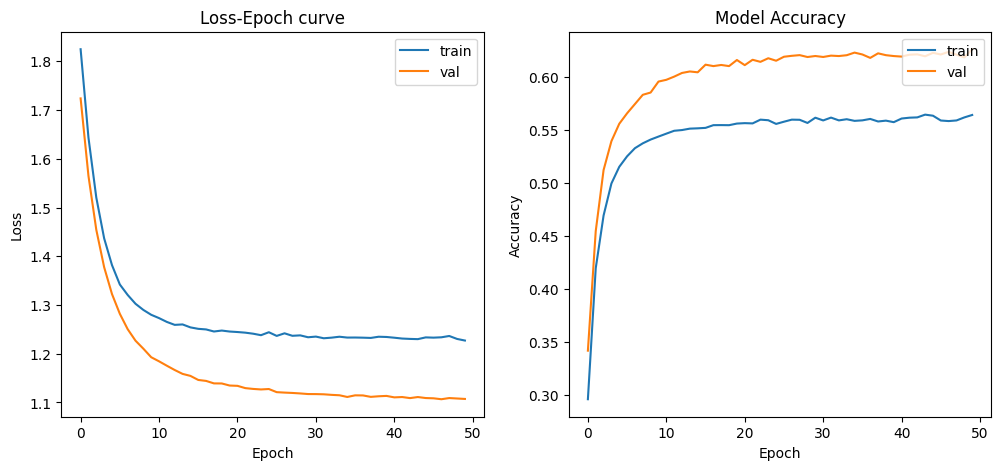

In [83]:
best_val_acc, best_val_loss = 0.0, 100.0
best_model = None

train_loss_epoch, val_loss_epoch = [], []
train_acc_epoch, val_acc_epoch = [], []

for e in range(num_epochs):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, (sentence, label) in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()

        attention_mask = sentence['attention_mask'].to(device)
        input_ids = sentence['input_ids'].squeeze(1).to(device)

        label = label.to(device)

        out = model(input_ids, attention_mask)
        loss = loss_fn(out, label)

        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        train_acc += calc_accuracy(out, label)

    tot_train_acc = train_acc / (batch_id+1)
    mean_train_loss = train_loss / (batch_id+1)
    train_loss_epoch.append(mean_train_loss)
    train_acc_epoch.append(tot_train_acc)
    print("epoch {} train acc {} loss {}".format(e+1, tot_train_acc, mean_train_loss))

    model.eval()
    for batch_id, (sentence, label) in enumerate(tqdm.notebook.tqdm(valid_dataloader)):

        attention_mask = sentence['attention_mask'].to(device)
        input_ids = sentence['input_ids'].squeeze(1).to(device)

        label = label.long().to(device)

        out = model(input_ids, attention_mask)
        loss = loss_fn(out, label)
        val_loss += loss.item()
        val_acc += calc_accuracy(out, label)
    tot_acc = val_acc / (batch_id+1)
    mean_val_loss = val_loss / (batch_id+1)
    val_loss_epoch.append(mean_val_loss)
    val_acc_epoch.append(tot_acc)
    print("epoch {} valid acc {} loss {}".format(e+1, tot_acc, mean_val_loss))
    if best_val_loss > mean_val_loss:
      clear_output(wait=True)
      print("epoch {} train acc {} validation acc {}".format(e+1, tot_train_acc, tot_acc))
      loss_epoch_curve(train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch)
      mean_val_loss = mean_val_loss
      best_model = deepcopy(model.state_dict())
      save_checkpoint(e, model, optimizer, model_path, 'roberta-large_simple_best.pt')

In [ ]:
model_path = '/content/drive/MyDrive/sentiment_test'
torch.save(best_model, os.path.join(model_path, 'roberta-large_5k-samples_7emotions_0423.pt'))

In [ ]:
save_checkpoint(epoch, model, optimizer, model_path, 'roberta-large_5k-samples_7emotions_0423.pt')

In [ ]:
plt.plot(train_loss_epoch)
plt.plot(val_loss_epoch)
plt.title('Loss-Epoch curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [86]:
config = {"labels":labels}

In [87]:
import pickle
with open('roberta-large_simple_config.pickle','wb') as fw:
    pickle.dump(config, fw)

# Evaluation

In [ ]:
model.eval()
val_acc = 0.0
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm.notebook.tqdm(test_dataloader)):
  token_ids = token_ids.long().to(device)
  segment_ids = segment_ids.long().to(device)
  valid_length = valid_length
  label = label.long().to(device)
  out = model(token_ids, valid_length, segment_ids)
  val_acc += calc_accuracy(out, label)
tot_acc = val_acc / (batch_id+1)
print(f"Test acc {tot_acc}")

In [ ]:
def get_model(bertmodel, baseline_model, model_file, num_classes):
  pre_trained_model = baseline_model(bertmodel, num_classes=num_classes, dr_rate=0.5).to(device)
  pre_trained_model.load_state_dict(torch.load(model_file))

  return pre_trained_model

def evaluation(model, text, tokenizer, vocab, labels):

  text = (text, )
  tok = tokenizer.tokenize
  trainset = BERTDataset(text, 0, 1, tok, vocab, 64, True, False)

  model.eval()
  token_ids = trainset[0].long().to(device)
  segment_ids = trainset[2].long().to(device)
  valid_length = trainset[1]
  out = model(token_ids, valid_length, segment_ids)

  return labels[out.argmax().item()]